<a href="https://colab.research.google.com/github/theindianwriter/cs6910_assignment1/blob/forward_backward_prop/DL_Assigment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

In [8]:
from keras.datasets import fashion_mnist

In [9]:
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [10]:
class_label = ['T-shirt/top', 
           'Trousers', 
           'Pullover', 
           'Dress', 'Coat', 
           'Sandal', 
           'Shirt', 
           'Sneaker', 
           'Bag', 
           'Ankle boot']

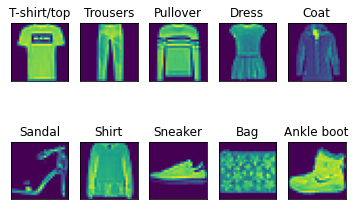

In [11]:
rows = 2
cols = 5
fig = plt.figure()
ax = []
j = 0
for i in range(1,rows*cols + 1):
  ax.append(fig.add_subplot(rows,cols,i))
  pos = np.where(y_train == j)
  plt.imshow(x_train[pos[0][0]])
  plt.xticks([])
  plt.yticks([])
  ax[-1].set_title(class_label[j])
  j += 1
plt.show()


In [23]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

  

In [26]:
class Network:
  def __init__(self,layers,weight_initilizer = "random"):
    

    if weight_initilizer == 'random':
      self.random(layers)
    elif weight_initilizer == 'Xavier':
      self.Xavier(layers)
    else:
      print("ERROR")


  def random(self,layers):
    self.biases = [np.random.randn(x,1) for x in layers[1:]]
    self.weights = [np.random.randn(x,y) for x,y in zip(layers[1:],layers[:-1])]


  def Xavier(self,layers):
    self.biases = []
    self.weights = []
    print("IMPLEMENTATION OF XAVIER")


  def show_network(self):
    print(self.biases)
    print(self.weights)

  def perform_activation(self,a):

    if self.activation == 'sigmoid':
      h = sigmoid(a)
    else:
      print("ERROR")

    return h

  def perform_output_function(self,a):

    if self.output_function == "softmax":
      h = softmax(a)
    else:
      print("ERROR")

    return h

  def forward_propagation(self,x):
    #input vector to the network
    a_i = x
    #array to store pre-activation vectors of the hidden layers and output layer
    a = []
    #array to store post activation vectors of the input layer,hidden layers and ouput layer
    h = [x]
    #calulating the pre-activation and post-activation vectors in the hidden layers
    for w,b in zip(self.weights[:-1],self.biases[:-1]):
      a_i = np.dot(w,p_a_i) + b
      a.append(a_i)
      h_i = self.perform_activation(a_i)
      h.append(h_i)

    #calculating the pre-activation and post-activation vector in the output layer
    w,b = self.weights[-1],self.biases[-1]
    a_o = np.dot(w,a[-1]) + b
    a.append(a_o)
    h_o = perform_output_function(a_o)
    h.append(h_o)
    return a,h

  def compile(self,optimizer = "sgd",loss = "squared-error",activation = "sigmoid",output_function = "softmax",metrics = "accuracy"):

    self.activation = activation
    self.output_function = output_function
    self.optimizer = optimizer
    self.loss = loss
    self.metrics = metrics
